# Nearest Neighbors

When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. -- it can be useful to get a list of related material. To find relevant documents you typically
* Decide on a notion of similarity
* Find the documents that are most similar 

In the assignment you will
* Gain intuition for different notions of similarity and practice finding similar documents. 
* Explore the tradeoffs with representing documents using raw word counts and TF-IDF
* Explore the behavior of different distance metrics by looking at the Wikipedia pages most similar to President Obama’s page.

## Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import json
import string
import scipy.sparse
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
%matplotlib inline

## Load Wikipedia dataset

We will be using the same dataset of Wikipedia pages that we used in the Machine Learning Foundations course (Course 1). Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase).  

In [2]:
wiki = pd.read_csv('people_wiki.csv')

In [3]:
wiki

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...
...,...,...,...
59066,<http://dbpedia.org/resource/Olari_Elts>,Olari Elts,olari elts born april 27 1971 in tallinn eston...
59067,<http://dbpedia.org/resource/Scott_F._Crago>,Scott F. Crago,scott francis crago born july 26 1963 twin bro...
59068,<http://dbpedia.org/resource/David_Cass_(footb...,David Cass (footballer),david william royce cass born 27 march 1962 in...
59069,<http://dbpedia.org/resource/Keith_Elias>,Keith Elias,keith hector elias born february 3 1972 in lac...


## Extract word count vectors

**Note** : Although the assignment uses the code below to load sparse matrix, note that **people_wiki_word_count.npz** provided infact *is not a sparse matrix*. Hence we will not be able to fit KNeighborsClassier on it. As a word around, np.load is used which will allow fitting to the word_count. Alternatively, CountVectorizer from sklearn can be used to create a sparse matrix which can then be used to fit KNeighborsClassier on.

In [4]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    return csr_matrix( (data, indices, indptr), shape)
        
word_count = load_sparse_csr('people_wiki_word_count.npz')

In [5]:
word_count

<59071x547979 sparse matrix of type '<class 'numpy.int64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [6]:
with open('people_wiki_map_index_to_word.json') as people_wiki_map_index_to_word:    
    map_index_to_word = json.load(people_wiki_map_index_to_word)

(Optional) Extracting word count vectors yourself. We provide the pre-computed word count vectors to minimize potential compatibility issues. You are free to experiment with other tools to compute the word count vectors yourself. A good place to start is sklearn.CountVectorizer. Note. Due to variations in tokenization and other factors, your word count vectors may differ from the ones we provide. For the purpose the assessment, we ask you to use the vectors from people_wiki_word_count.npz.

In [7]:
def remove_punctuation(text):
    text = text.translate(str.maketrans('','',string.punctuation)) 
    
    return text

wiki['text_clean'] = wiki['text'].apply(remove_punctuation)

In [8]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
word_count_matrix = vectorizer.fit_transform(wiki['text_clean'])

In [9]:
word_count_matrix

<59071x548552 sparse matrix of type '<class 'numpy.int64'>'
	with 10379254 stored elements in Compressed Sparse Row format>

## Find nearest neighbors

Let's start by finding the nearest neighbors of the Barack Obama page using the word count vectors to represent the articles and Euclidean distance to measure distance. For this, we will use scikit-learn's implementation of k-nearest neighbors. We first create an instance of the NearestNeighbor class, specifying the model parameters. Then we call the fit() method to attach the training set.

In [10]:
clf = NearestNeighbors(metric='euclidean', algorithm='brute')
model = clf.fit(word_count)

Obtain the row number for Obama's article

In [11]:
wiki[wiki['name'] == 'Barack Obama']

,URI,name,text,text_clean
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,barack hussein obama ii brk husen bm born augu...


Let us run the k-nearest neighbor algorithm with Obama's article. Since the NearestNeighbor class expects a vector, we pass the 35817th row of word_count vector.

In [12]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10) # 1st arg: word count vector

In [13]:
distances

array([[ 0.        , 33.07567082, 34.39476704, 36.15245497, 36.16628264,
        36.33180425, 36.40054945, 36.49657518, 36.63331817, 36.95943723]])

In [14]:
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
neighbors['id'].dtype

dtype('int64')

In [15]:
wiki['id'] = wiki.index
pd.merge(wiki, neighbors, how = 'inner', on='id')[['id','name','distance']].sort_values('distance', ascending = True)

,id,name,distance
8,35817,Barack Obama,0.000000
4,24478,Joe Biden,33.075671
5,28447,George W. Bush,34.394767
7,35357,Lawrence Summers,36.152455
2,14754,Mitt Romney,36.166283
1,13229,Francisco Barrio,36.331804
6,31423,Walter Mondale,36.400549
3,22745,Wynn Normington Hugh-Jones,36.496575
9,36364,Don Bonker,36.633318
0,9210,Andy Anstett,36.959437


## Interpreting the Nearest Neighbors

All of the 10 people are politicians, but about half of them have rather tenuous connections with Obama, other than the fact that they are politicians.

* Francisco Barrio is a Mexican politician, and a former governor of Chihuahua.
* Walter Mondale and Don Bonker are Democrats who made their career in late 1970s.
* Wynn Normington Hugh-Jones is a former British diplomat and Liberal Party official.
* Andy Anstett is a former politician in Manitoba, Canada.

Nearest neighbors with raw word counts got some things right, showing all politicians in the query result, but missed finer and important details.

For instance, let's find out why Francisco Barrio was considered a close neighbor of Obama. To do this, let's look at the most frequently used words in each of Barack Obama and Francisco Barrio's pages.

First, run the following cell to obtain the word_count column, which represents the word count vectors in the dictionary form. This way, we can quickly recognize words of great importance.

**Note** : Understanding this code is not required for completing this assignment. Feel free to treat it as a black box.

In [16]:
def unpack_dict(matrix, map_index_to_word):
    table = sorted(map_index_to_word, key=map_index_to_word.get)
    
    
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in range(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

In [17]:
wiki

,URI,name,text,text_clean,id,word_count
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,digby morrell born 10 october 1979 is a former...,0,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,alfred j lewy aka sandy lewy graduated from un...,1,"{'maladaptation': 1, 'phasedelay': 1, '25hour'..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,harpdog brown is a singer and harmonica player...,2,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,franz rottensteiner born in waidmannsfeld lowe...,3,"{'fantasticrottensteiner': 1, 'waidmannsfeld':..."
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,henry krvits born 30 december 1974 in tallinn ...,4,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '..."
...,...,...,...,...,...,...
59066,<http://dbpedia.org/resource/Olari_Elts>,Olari Elts,olari elts born april 27 1971 in tallinn eston...,olari elts born april 27 1971 in tallinn eston...,59066,"{'orchestraolaris': 1, 'ivth': 1, 'nyyd': 1, '..."
59067,<http://dbpedia.org/resource/Scott_F._Crago>,Scott F. Crago,scott francis crago born july 26 1963 twin bro...,scott francis crago born july 26 1963 twin bro...,59067,"{'procushion': 1, '5088376': 1, 'trafton': 3, ..."
59068,<http://dbpedia.org/resource/David_Cass_(footb...,David Cass (footballer),david william royce cass born 27 march 1962 in...,david william royce cass born 27 march 1962 in...,59068,"{'3257': 1, '15696': 1, 'grewcock': 1, 'orient..."
59069,<http://dbpedia.org/resource/Keith_Elias>,Keith Elias,keith hector elias born february 3 1972 in lac...,keith hector elias born february 3 1972 in lac...,59069,"{'recordselias': 1, 'cochampionship': 1, 'xfl'..."


To make things even easier, we provide a utility function that displays a dictionary in tabular form:

In [18]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    dic = row['word_count'].iloc[0]
    word_count_ = pd.DataFrame(dic.items(), columns=['word','count'])
    word_count_table = word_count_.sort_values(['count'], ascending=False)
    #word_count_table = word_count_table.fillna(0)
    #word_count_table = row[['word_count']].stack('word_count', new_column_name=['word','count'])
    return word_count_table #word_count_table.sort('count', ascending=False)

obama_words = top_words('Barack Obama')
print('Obama Word Count')
display(obama_words.head(10))
print('\n')
barrio_words = top_words('Francisco Barrio')
print('Barrio Word Count')
display(barrio_words.head(10))

Obama Word Count


,word,count
272,the,40
270,in,30
271,and,21
269,of,18
266,to,14
258,his,11
71,obama,9
138,act,8
260,he,7
268,a,7




Barrio Word Count


,word,count
224,the,36
221,of,24
223,and,18
222,in,17
212,he,10
218,to,9
19,chihuahua,7
220,a,6
111,governor,6
210,his,5


Let's extract the list of most frequent words that appear in both Obama's and Barrio's documents. We've so far sorted all words from Obama and Barrio's articles by their word frequencies. We will now use a dataframe operation known as **join**. The **join** operation is very useful when it comes to playing around with data: it lets you combine the content of two tables using a shared column (in this case, the word column).

In [19]:
combined_words = pd.merge(obama_words, barrio_words, how = 'inner', on = 'word')
combined_words.head(10)

,word,count_x,count_y
0,the,40,36
1,in,30,17
2,and,21,18
3,of,18,24
4,to,14,9
5,his,11,5
6,he,7,10
7,a,7,6
8,as,6,5
9,was,5,4


In [20]:
combined_words = combined_words.rename(columns = {'count_x': 'Obama', 'count_y': 'Barrio'})
combined_words.head(10)

,word,Obama,Barrio
0,the,40,36
1,in,30,17
2,and,21,18
3,of,18,24
4,to,14,9
5,his,11,5
6,he,7,10
7,a,7,6
8,as,6,5
9,was,5,4


**Note**: The join operation does not enforce any particular ordering on the shared column. So to obtain, say, the five common words that appear most often in Obama's article, sort the combined table by the Obama column. Don't forget ascending=False to display largest counts first.

In [21]:
display(combined_words.sort_values('Obama', ascending=False).head())

# The code below is to answer the following quiz question

common_words = set([m for m in combined_words['word'].iloc[0:5]])

def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set([k for k,v in word_count_vector.items()])
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return common_words.issubset(unique_words)

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)


# The code below is to answer the following quiz question
num_reviews_top_words = sum(wiki['has_top_words'] == True)

print('\n\n' + str(num_reviews_top_words) + ' contain top 5 most frequently appearing words')

,word,Obama,Barrio
0,the,40,36
1,in,30,17
2,and,21,18
3,of,18,24
4,to,14,9




56066 contain top 5 most frequently appearing words


<font color='steelblue'><b> Quiz : Among the words that appear in both Barack Obama and Francisco Barrio, take the 5 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words? </b></font>

<font color='mediumvioletred'><b> Answer : {{num_reviews_top_words}} reviews contain top 5 most frequently appearing words </b></font>

**Checkpoint**. Check your has_top_words function on two random articles

In [22]:
print('Output from your function:', has_top_words(wiki['word_count'].iloc[32]))
print('Correct output: True')
print('Also check the length of unique_words. It should be 167')
print('Lenth of unique_words : ', len(wiki['word_count'].iloc[32]))
print('\n')
print('Output from your function:', has_top_words(wiki['word_count'].iloc[33]))
print('Correct output: False')
print('Also check the length of unique_words. It should be 188')
print('Lenth of unique_words : ', len(wiki['word_count'].iloc[33]))


# The code below is used to answer the following quiz question
print('\n========================================================\n')

obama = word_count[wiki.index[wiki['name'] == 'Barack Obama'].tolist()]
bush = word_count[wiki.index[wiki['name'] == 'George W. Bush'].tolist()]
biden = word_count[wiki.index[wiki['name'] == 'Joe Biden'].tolist()]

obama_bush = euclidean_distances(obama, bush)
obama_biden = euclidean_distances(obama, biden)
bush_biden = euclidean_distances(bush, biden)

eucl_dists = {'Obama and Bush' : obama_bush, 'Obama and Biden' : obama_biden, 'Bush and Biden' : bush_biden}

min_dist = min(eucl_dists, key=eucl_dists.get)
min_dist_value = min(eucl_dists.values())

print('Euclidean Distance between Obama and Bush :',*obama_bush[0])
print('Euclidean Distance between Obama and Biden :',*obama_biden[0])
print('Euclidean Distance between Bush and Biden :',*bush_biden[0])
print('\nThe minimum distance is between', min_dist, ' with distance of', *min_dist_value[0])

print('\n\n')

obama_words = top_words('Barack Obama')
bush_words = top_words('George W. Bush')

obama_bush = pd.merge(obama_words, bush_words, how='inner', on = 'word')

obama_bush = obama_bush.rename(index=str, columns={'count_x':'Obama', 'count_y':'Bush'})
top_10_words = list(obama_bush['word'].iloc[0:10])

print('Top 10 words in Obama :', top_10_words)

Output from your function: True
Correct output: True
Also check the length of unique_words. It should be 167
Lenth of unique_words :  167


Output from your function: False
Correct output: False
Also check the length of unique_words. It should be 188
Lenth of unique_words :  188


Euclidean Distance between Obama and Bush : 34.39476704383968
Euclidean Distance between Obama and Biden : 33.075670817082454
Euclidean Distance between Bush and Biden : 32.7566787083184

The minimum distance is between Bush and Biden  with distance of 32.7566787083184



Top 10 words in Obama : ['the', 'in', 'and', 'of', 'to', 'his', 'act', 'he', 'a', 'law']


<font color='steelblue'><b> Quiz 1 : mong the words that appear in both Barack Obama and Francisco Barrio, take the 5 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words? </b></font>

<font color='mediumvioletred'><b> Answer 1 : The minimum distance is between {{min_dist}} with distance of {{str(*min_dist_value[0])}} </b></font>

<br/>

<font color='steelblue'><b> Quiz 2 : Collect all words that appear both in Barack Obama and George W. Bush pages. Out of those words, find the 10 words that show up most often in Obama's page. </b></font>

<font color='mediumvioletred'><b> Answer 2 : {{top_10_words}} show most often in Obama's page </b></font>

**Note.** Even though common words are swamping out important subtle differences, commonalities in rarer political words still matter on the margin. This is why politicians are being listed in the query result instead of musicians, for example. In the next subsection, we will introduce a different metric that will place greater emphasis on those rarer words.

## Extract the TF-IDF Vectors

Much of the perceived commonalities between Obama and Barrio were due to occurrences of extremely frequent words, such as "the", "and", and "his". So the nearest neighbors algorithm is recommending plausible results sometimes for the wrong reasons.

To retrieve articles that are more relevant, we should focus more on rare words that don't happen in every article. TF-IDF (term frequency–inverse document frequency) is a feature representation that penalizes words that are too common. Let us load in the TF-IDF vectors and repeat the nearest neighbor search.

For your convenience, we extracted the TF-IDF vectors from the dataset. The vectors are packaged in a sparse matrix, where the i-th row gives the TF-IDF vectors for the i-th document. Each column corresponds to a unique word appearing in the dataset. The mapping between words and integer indices are given in people_wiki_map_index_to_word.gl.

In [23]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')

In addition to the sparse matrix, we also store the TF-IDF vectors in dictionary form as well, to allow for easy interpretation.

In [24]:
wiki['tf_idf'] = unpack_dict(tf_idf, map_index_to_word)

(Optional) Extracting TF-IDF vectors yourself. We provide the pre-computed TF-IDF vectors to minimize potential compatibility issues. You are free to experiment with other tools to compute the TF-IDF vectors yourself. A good place to start is sklearn.TfidfVectorizer. Note. Due to variations in tokenization and other factors, your TF-IDF vectors may differ from the ones we provide. For the purpose the assessment, we ask you to use the vectors from people_wiki_tf_idf.npz.

In [25]:
tf = TfidfVectorizer(analyzer='word', min_df = 0, stop_words = 'english')
corpus = [i for i in wiki['text_clean']]
tfidf_matrix =  tf.fit_transform(corpus)
feature_names = tf.get_feature_names()

In [26]:
tfidf_matrix

<59071x548202 sparse matrix of type '<class 'numpy.float64'>'
	with 8078045 stored elements in Compressed Sparse Row format>

## Find nearest neighbors using TF-IDF vectors

Since we are now using a different set of features, we should create a new nearest neighbor model. Create another instance of the NearestNeighbor class as follows. Then call the fit() method to associate it with the TF-IDF vectors.

In [27]:
clf_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf = clf_tf_idf.fit(tf_idf)

Perform the nearest neighbor search

In [28]:
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=10)

To print the names of the articles, we perform join using the indices

In [29]:
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
neighbors['id'].dtype

dtype('int64')

In [30]:
wiki['id'] = wiki.index
pd.merge(wiki, neighbors, how = 'inner', on='id')[['id','name','distance']].sort_values('distance', ascending = True)

,id,name,distance
3,35817,Barack Obama,0.000000
1,7914,Phil Schiliro,106.861014
9,46811,Jeff Sessions,108.871674
7,44681,Jesse Lee (politician),109.045698
4,38376,Samantha Power,109.108106
0,6507,Bob Menendez,109.781867
5,38714,Eric Stern (politician),109.957788
8,44825,James A. Guest,110.413889
6,44368,Roland Grossenbacher,110.470609
2,33417,Tulsi Gabbard,110.696998


Let's determine whether this list makes sense.

With a notable exception of Roland Grossenbacher, the other 8 are all American politicians who are contemporaries of Barack Obama.
Phil Schiliro, Jesse Lee, Samantha Power, and Eric Stern worked for Obama.
Clearly, the results are more plausible with the use of TF-IDF. Let's take a look at the word vector for Obama and Schilirio's pages. Notice that TF-IDF representation assigns a weight to each word. This weight captures relative importance of that word in the document. Let us sort the words in Obama's article by their TF-IDF weights; we do the same for Schiliro's article as well.

In [31]:
def top_words_tf_idf(name):
    
    row = wiki[wiki['name'] == name]
    
    for i in row['tf_idf']:
        word_count_table = pd.DataFrame(i.items(), columns = ['word','weight'])
        
    return word_count_table.sort_values('weight', ascending=False)

obama_tf_idf = top_words_tf_idf('Barack Obama')
print('Obama Word Weight Table')
display(obama_tf_idf.head())
print('\n')
print('Schiliro Word Weight Table')
schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
display(schiliro_tf_idf.head())

Obama Word Weight Table


,word,weight
71,obama,43.295653
138,act,27.678223
97,iraq,17.747379
129,control,14.887061
191,law,14.722936




Schiliro Word Weight Table


,word,weight
1,schiliro,21.972991
42,staff,15.856442
17,congressional,13.547088
0,daschleschiliro,10.986495
13,obama,9.621256


Using the join operation we learned earlier, try your hands at computing the common words shared by Obama's and Schiliro's articles. Sort the common words by their TF-IDF weights in Obama's document. The first 10 words should say: Obama, law, democratic, Senate, presidential, president, policy, states, office, 2011.

In [32]:
combined_words_tfidf = pd.merge(obama_tf_idf, schiliro_tf_idf, how = 'inner', on = 'word')

In [33]:
combined_words_tfidf = combined_words_tfidf.sort_values('weight_x', ascending=False)[0:10]
combined_words_tfidf = combined_words_tfidf.rename(index=str, columns={'weight_x':'Weight Obama', 'weight_y':'Weight Barrio'})
combined_words_tfidf

,word,Weight Obama,Weight Barrio
0,obama,43.295653,9.621256
1,law,14.722936,7.361468
2,democratic,12.410689,6.205344
3,senate,10.164288,3.388096
4,presidential,7.386955,3.693478
5,president,7.226869,9.033587
6,policy,6.095386,3.047693
7,states,5.473201,1.824400
8,office,5.248173,2.624086
9,2011,5.107041,3.404694


In [34]:
common_words_tfid = set([m for m in combined_words_tfidf['word'].iloc[0:5]])

def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set([k for k,v in word_count_vector.items()])
    # return True if common_words is a subset of unique_words
    # return False otherwise
    return common_words_tfid.issubset(unique_words)

wiki['has_top_words_tfid'] = wiki['word_count'].apply(has_top_words)

# The code below is used to answer the quiz question
num_reviews_top_words_tfid = sum(wiki['has_top_words_tfid'] == True)

print(num_reviews_top_words_tfid, 'contain top 5 most frequently appearing words')

14 contain top 5 most frequently appearing words


<font color='steelblue'><b> Quiz : Among the words that appear in both Barack Obama and Francisco Barrio, take the 5 that appear most frequently in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words? </b></font>

<font color='mediumvioletred'><b> Answer : {{num_reviews_top_words_tfid}} reviews contain top 5 most frequently appearing words </b></font>

Notice the huge difference in this calculation using TF-IDF scores instead of raw word counts. We've eliminated noise arising from extremely common words.

## Choosing Metrics

You may wonder why Joe Biden, Obama's running mate in two presidential elections, is missing from the query results of model_tf_idf. Let's find out why. First, compute the distance between TF-IDF features of Obama and Biden.

In [35]:
obama_tfidf = tf_idf[wiki.index[wiki['name'] == 'Barack Obama'].tolist()]
biden_tfidf = tf_idf[wiki.index[wiki['name'] == 'Joe Biden'].tolist()]

obama_biden_tfid = euclidean_distances(obama_tfidf, biden_tfidf)


print('Euclidean Distance between Obama and Biden :',*obama_biden_tfid[0])

print('\n')

obama_words = top_words('Barack Obama')
biden_words = top_words('Joe Biden')

obama_biden = pd.merge(obama_words, biden_words, how='inner', on = 'word')

obama_biden = obama_biden.rename(index=str, columns={'count_x':'Obama', 'count_y':'Biden'})
top_10_words = list(obama_biden['word'].iloc[0:10])

print('Top 10 words in Obama :', top_10_words)

Euclidean Distance between Obama and Biden : 123.29745600964289


Top 10 words in Obama : ['the', 'in', 'and', 'of', 'to', 'his', 'obama', 'act', 'he', 'a']


<font color='steelblue'><b> Quiz : Compute the Euclidean distance between TF-IDF features of Obama and Biden </b></font>

<font color='mediumvioletred'><b> Answer : The euclidean distance between Obama and Biden is {{str(*obama_biden_tfid[0])}} </b></font>

The distance is larger than the distances we found for the 10 nearest neighbors. But one may wonder, is Biden's article that different from Obama's, more so than, say, Schiliro's? It turns out that, when we compute nearest neighbors using the Euclidean distances, we unwittingly favor short articles over long ones. Let us compute the length of each Wikipedia document, and examine the document lengths for the 100 nearest neighbors to Obama's page.

In [36]:
def compute_length(row):
    return len(row['text'].split(' '))


wiki['length'] = wiki.apply(compute_length, axis=1)

# Compute 100 nearest neighbors and display their lengths
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_euclidean = pd.merge(wiki, neighbors, on = 'id')[['id', 'name', 'length', 'distance']].sort_values('distance')

display(nearest_neighbors_euclidean)

,id,name,length,distance
58,35817,Barack Obama,540,0.000000
18,7914,Phil Schiliro,208,106.861014
79,46811,Jeff Sessions,230,108.871674
76,44681,Jesse Lee (politician),216,109.045698
63,38376,Samantha Power,310,109.108106
...,...,...,...,...
22,9884,Kenneth M. Pollack,229,113.784257
91,55613,Gary D. Solis,208,113.785437
11,6828,George J. Mitchell,214,113.793053
43,22695,Nicholas Liverpool,251,113.795142


To see how these document lengths compare to the lengths of other documents in the corpus, let's make a histogram of the document lengths of Obama's 100 nearest neighbors and compare to a histogram of document lengths for all documents.

c:\users\ahmed ismail khalid\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\ahmed ismail khalid\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


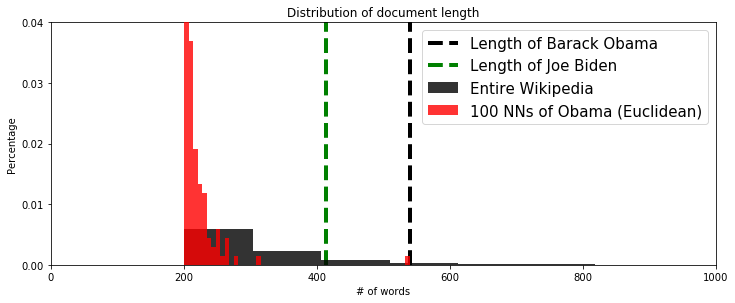

In [37]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].iloc[0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].iloc[0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

Relative to the rest of Wikipedia, nearest neighbors of Obama are overwhelmingly short, most of them being shorter than 300 words. The bias towards short articles is not appropriate in this application as there is really no reason to favor short articles over long articles (they are all Wikipedia articles, after all). Many Wikipedia articles are 300 words or more, and both Obama and Biden are over 300 words long.

**Note**: For the interest of computation time, the dataset given here contains excerpts of the articles rather than full text. For instance, the actual Wikipedia article about Obama is around 25000 words. Do not be surprised by the low numbers shown in the histogram.

**Note**: Both word-count features and TF-IDF are proportional to word frequencies. While TF-IDF penalizes very common words, longer articles tend to have longer TF-IDF vectors simply because they have more words in them.

To remove this bias, we turn to **cosine distances**:
$$
d(\mathbf{x},\mathbf{y}) = 1 - \frac{\mathbf{x}^T\mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|}
$$
Cosine distances let us compare word distributions of two articles of varying lengths.

Let us train a new nearest neighbor model, this time with cosine distances.  We then repeat the search for Obama's 100 nearest neighbors.

Let us train a new nearest neighbor model, this time with cosine distances. We then repeat the search for Obama's 100 nearest neighbors.

In [38]:
clf_tf_idf_2 = NearestNeighbors(algorithm='brute', metric='cosine')
model_tf_idf_2 = clf_tf_idf_2.fit(tf_idf)

distances, indices = model_tf_idf_2.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_cosine = pd.merge(wiki,neighbors, on='id')[['id', 'name', 'length', 'distance']].sort_values('distance')

nearest_neighbors_cosine.head()

,id,name,length,distance
59,35817,Barack Obama,540,0.000000
45,24478,Joe Biden,414,0.703139
65,38376,Samantha Power,310,0.742982
98,57108,Hillary Rodham Clinton,580,0.758358
67,38714,Eric Stern (politician),255,0.770561


From a glance at the above table, things look better. For example, we now see Joe Biden as Barack Obama's nearest neighbor! We also see Hillary Clinton on the list. This list looks even more plausible as nearest neighbors of Barack Obama.

Let's make a plot to better visualize the effect of having used cosine distance in place of Euclidean on our TF-IDF vectors.

c:\users\ahmed ismail khalid\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
c:\users\ahmed ismail khalid\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
c:\users\ahmed ismail khalid\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


<Figure size 756x324 with 0 Axes>

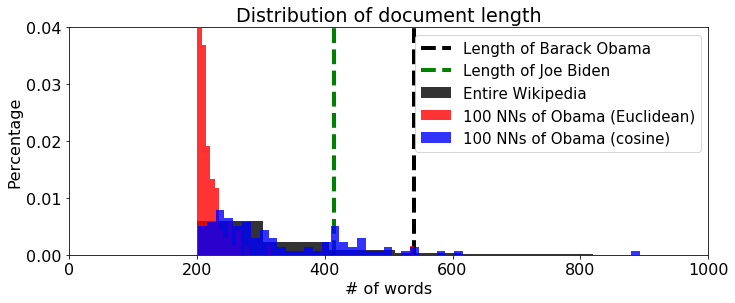

In [39]:
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].iloc[0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].iloc[0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

Indeed, the 100 nearest neighbors using cosine distance provide a sampling across the range of document lengths, rather than just short articles like Euclidean distance provided.

Moral of the story: In deciding the features and distance measures, check if they produce results that make sense for your particular application.

## Problem with Cosine Distances : Tweets vs. Long Articles

Happily ever after? Not so fast. Cosine distances ignore all document lengths, which may be great in certain situations but not in others. For instance, consider the following (admittedly contrived) example.

```
+--------------------------------------------------------+
|                                             +--------+ |
|  One that shall not be named                | Follow | |
|  @username                                  +--------+ |
|                                                        |
|  Democratic governments control law in response to     |
|  popular act.                                          |
|                                                        |
|  8:05 AM - 16 May 2016                                 |
|                                                        |
|  Reply   Retweet (1,332)   Like (300)                  |
|                                                        |
+--------------------------------------------------------+
```

How similar is this tweet to Barack Obama's Wikipedia article? Let's transform the tweet into TF-IDF features, using an encoder fit to the Wikipedia dataset.  (That is, let's treat this tweet as an article in our Wikipedia dataset and see what happens.)

In [40]:
tweet = {'act': 3.4597778278724887,
 'control': 3.721765211295327,
 'democratic': 3.1026721743330414,
 'governments': 4.167571323949673,
 'in': 0.0009654063501214492,
 'law': 2.4538226269605703,
 'popular': 2.764478952022998,
 'response': 4.261461747058352,
 'to': 0.04694493768179923}

Let's look at the TF-IDF vectors for this tweet and for Barack Obama's Wikipedia entry, just to visually see their differences.

In [41]:
word_indices = []

for word in tweet.keys():
    if word in map_index_to_word.keys():
        word_indices.append(map_index_to_word[word]  )

tweet_tf_idf = csr_matrix( (list(tweet.values()), ([0]*len(word_indices), word_indices)),
                          shape=(1, tf_idf.shape[1]) )

Now, compute the cosine distance between the Barack Obama article and this tweet

In [42]:
obama_tf_idf = tf_idf[35817]

cosine_distances(obama_tf_idf, tweet_tf_idf)

array([[0.70591838]])

Let's compare this distance to the distance between the Barack Obama article and all of its Wikipedia 10 nearest neighbors

In [43]:
distances, indices = model_tf_idf_2.kneighbors(obama_tf_idf, n_neighbors=10)

distances

array([[0.        , 0.70313868, 0.7429819 , 0.7583584 , 0.77056123,
        0.7846775 , 0.78803907, 0.79092642, 0.7983226 , 0.79946636]])

With cosine distances, the tweet is "nearer" to Barack Obama than everyone else, except for Joe Biden! This probably is not something we want. If someone is reading the Barack Obama Wikipedia page, would you want to recommend they read this tweet? Ignoring article lengths completely resulted in nonsensical results. In practice, it is common to enforce maximum or minimum document lengths. After all, when someone is reading a long article from The Atlantic, you wouldn't recommend him/her a tweet.